# Plot 3C waveforms of an event recorded on multiple stations 

In [163]:
# Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv, Timestamp, Timedelta
from os.path import join

from utils_basic import ROOTDIR, INNER_STATIONS_A, INNER_STATIONS_B, days_to_timestamps
from utils_preproc import read_and_process_windowed_waveforms
from utils_sta_lta import read_associated_events
from utils_snuffler import read_normal_markers
from utils_cc import get_timewin_from_template_name


In [164]:
# Inputs
rootdir = ROOTDIR
evname = "HighB16-22-01-27"
begin = -0.1
end = 0.15

freqmin = 10.0
freqmax = 450.0

scale_wf = 5e-4 # scale factor for plotting the waveforms
scale_ax = 5 # scale factor for plotting the axes
scalebar = 500 # scale bar length in nm/s

linewidth_wf = 1.5
linewidth_eb = 1

In [165]:
# Read the picks
timewin = get_timewin_from_template_name(evname)
inpath = join(rootdir, timewin, f"xpicks_{evname}.dat")
pickdf = read_normal_markers(inpath)

In [166]:
# Read and process the data
stream = read_and_process_windowed_waveforms(pickdf, freqmin, freqmax, begin=begin, end=end)
numsta = len(stream) // 3

B13


Saved to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-22-00-00/waveforms_HighB16-22-01-27.png


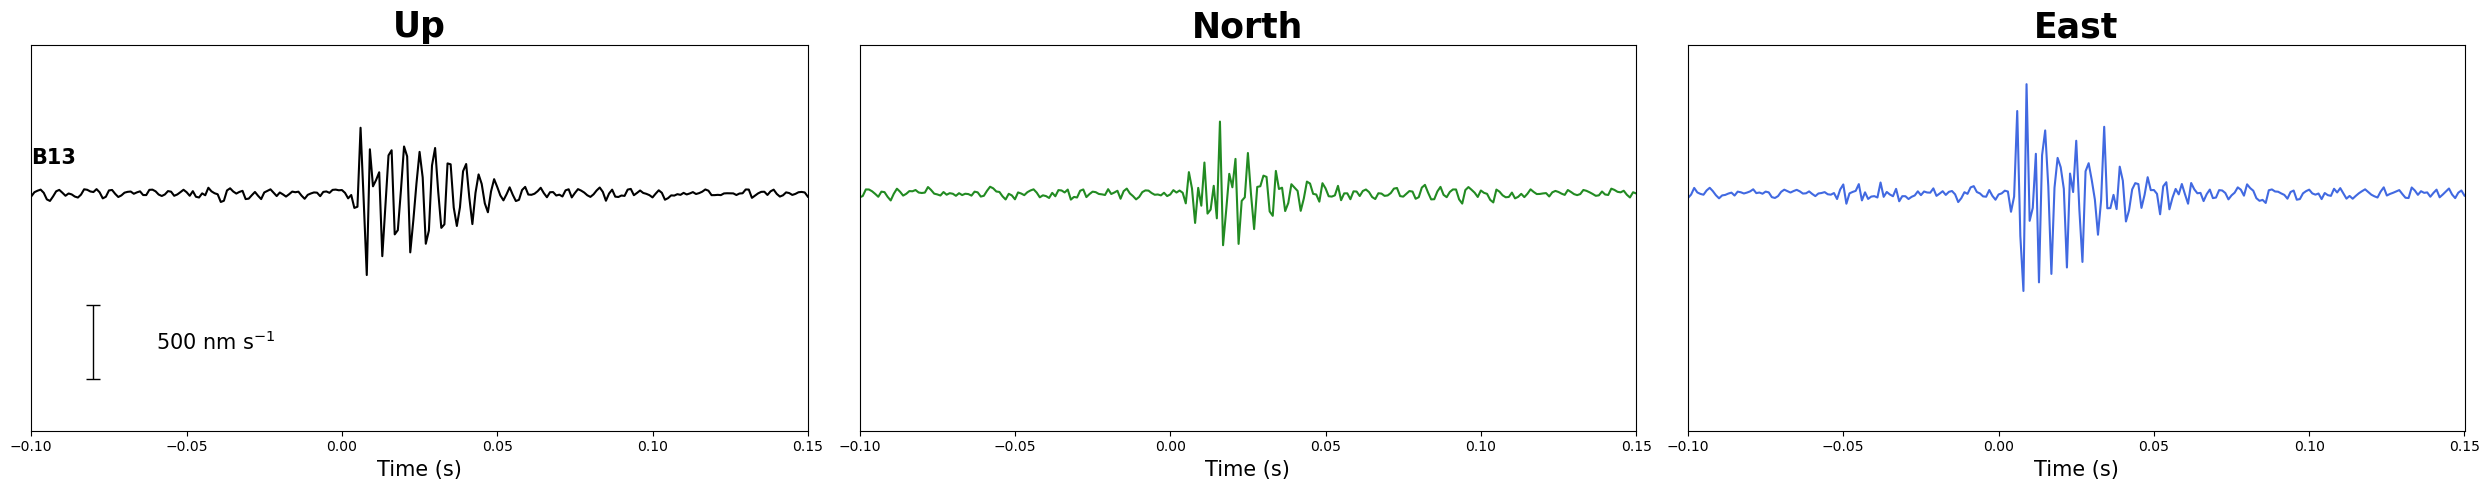

In [167]:
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(25, scale_ax*numsta))

### Loop over the stations
for i, station in enumerate(pickdf["station"]):

    #### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale_wf + i
        data_1 = trace_1.data * scale_wf + i
        data_2 = trace_2.data * scale_wf + i
    except:
        print(f"Could not plot {station}")
        continue
    
    #### Convert the time axis to Pandas Timestamps
    timeax = trace_z.times()+begin

    axes[0].plot(timeax, data_z, color="black", linewidth=linewidth_wf)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=linewidth_wf)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=linewidth_wf)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=15, fontweight="bold")

    # #### Extract and plot the raw detections
    # if plot_detect:
    #     try:
    #         detdf = stalta_dict[station]
    #         detdf = detdf.loc[(detdf["trigger_time"] >= timeax[0]) & (detdf["trigger_time"] <= timeax[-1])]
    #     except:
    #         print(f"No detections for {station}")
    #         continue

    #     axes[0].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
    #     axes[1].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)
    #     axes[2].scatter(detdf["trigger_time"], [i] * len(detdf), color="lightsalmon", zorder=10, s=size)

    # #### Extract and plot the associated detections
    # if plot_assoc:
    #     for event in events:
    #         try:
    #             trigger, detrigger = event.get_triggers_by_station(station)
    #         except:
    #             continue
            
    #         axes[0].scatter(trigger, i, color="red", zorder=11, s=size)
    #         axes[1].scatter(trigger, i, color="red", zorder=11, s=size)
    #         axes[2].scatter(trigger, i, color="red", zorder=11, s=size)

## Plot the scale_wf bar
y_center = -0.5
time_bar = begin+0.02
unit = "nm s$^{-1}$"
axes[0].errorbar(time_bar, y_center, yerr=scalebar * scale_wf/2, xerr=None, capsize=5, color='black', fmt='-', linewidth=linewidth_eb)
axes[0].text(time_bar + 0.02, y_center, f"{scalebar} {unit}", fontsize=15, va='center', ha='left')

## Set the x-axis limits
axes[0].set_xlim([timeax[0], timeax[-1]])
axes[1].set_xlim([timeax[0], timeax[-1]])
axes[2].set_xlim([timeax[0], timeax[-1]])

## Set the y-axis limits
axes[0].set_ylim([-0.8, numsta-0.5])

# ## Format x-axis as date time
# axes[0].xaxis.set_major_tick_params(rotation=45)
# axes[1].xaxis.set_major_tick_params(rotation=45)
# axes[2].xaxis.set_major_tick_params(rotation=45)

# for label in axes[0].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# for label in axes[1].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# for label in axes[2].get_xticklabels():
#     label.set_fontsize(15)
#     label.set_verticalalignment('top')
#     label.set_horizontalalignment('right')
#     label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=25, fontweight="bold")
axes[1].set_title("North", fontsize=25, fontweight="bold")
axes[2].set_title("East", fontsize=25, fontweight="bold")

# Set x labels
axes[0].set_xlabel("Time (s)", fontsize=15)
axes[1].set_xlabel("Time (s)", fontsize=15)
axes[2].set_xlabel("Time (s)", fontsize=15)


# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)

# Save the figure
filename = f"waveforms_{evname}.png"

outpath = join(ROOTDIR, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved to {outpath}")